## Conclusion

The final section is to build the random forest model to predict a video is claim or opinion.

1. The current version of the model is very good. `video_view_count`, `video_like_count`, `video_share_count`, `video_download` are the most important features to determine the video is claim or opinion.

2. Finally, to make the model more complete, it would be helpful to have the number of times the video was reported. It would also be useful to have the total number of user reports for all videos posted by each author.

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
# Load dataset into dataframe
df = pd.read_csv("tiktok_dataset.csv")

Inspect the first five rows of the dataframe.

In [3]:
# Display first few rows
df.head()


,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [4]:
# Get number of rows and columns
df.shape


(19382, 12)

In [5]:
# Get basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


Generate basic descriptive statistics about the dataset.

In [6]:
# Generate basic descriptive stats
df.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [7]:
# Check for missing values
df.isna().sum()


#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [8]:
# Drop rows with missing values
df = df.dropna(axis = 0)

In [9]:
# Check for duplicates
df.duplicated().sum()


0

In [10]:
# Check class balance
df["claim_status"].value_counts(normalize = True)


claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

In [11]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
df["text_length"] = df["video_transcription_text"].str.len()

In [12]:
# Calculate the average text_length for claims and opinions
df[["claim_status", "text_length"]].groupby("claim_status").mean()


,text_length
claim_status,
claim,95.376978
opinion,82.722562


Text(0.5, 1.0, 'Distribution of video_transcription_text_length for claims and opinions')

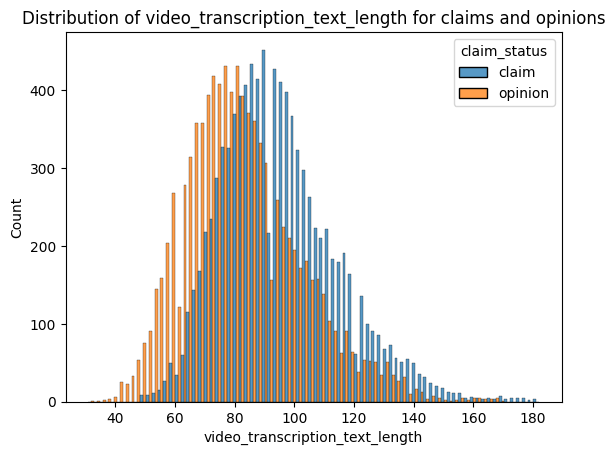

In [13]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot
sns.histplot(data = df, x = "text_length", hue = "claim_status", multiple = "dodge")
plt.xlabel("video_transcription_text_length")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text_length for claims and opinions")

In [14]:
# Create a copy of the X data
x = df.copy()

# Drop unnecessary columns
x = x.drop(["#", "video_id"], axis = 1)

# Encode target variable
x["claim_status"] = x["claim_status"].replace({"opinion" : 0, "claim" : 1})

# Dummy encode remaining categorical values
x = pd.get_dummies(x, columns = ["verified_status", "author_ban_status"], drop_first = True)


In [15]:
# Isolate target variable
y = x["claim_status"]
x = x.drop(["claim_status"], axis = 1)


In [16]:
# Split the data into training and testing sets
x_tr, x_test, y_tr, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Split the trainin data in to training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_tr, y_tr, test_size = 0.25, random_state = 0)


In [17]:
# Get shape of each training, validation, and testing set
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

In [18]:
# Set up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [19]:
# Extract numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(x_train['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)
x_train_final = pd.concat([x_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

# Display first few rows
x_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,134,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,97,False,True,False,...,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,76,False,False,True,...,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,58,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,57,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Extract numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(x_val['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
x_val_final = pd.concat([x_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)

# Display first few rows
x_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,72,False,False,True,...,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,96,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,88,False,False,False,...,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,83,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,104,False,False,True,...,0,0,0,0,0,0,0,1,0,0


In [21]:
# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(x_test['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
x_test_final = pd.concat([x_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
x_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,107,False,False,False,...,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,69,True,False,True,...,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,90,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,76,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,72,False,False,False,...,0,0,0,0,0,0,0,0,0,0


### **Build models**


#### **random forest model**

In [22]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state = 0)

# Create a dictionary of hyperparameters to tune
cv_params = {"max_depth" : [5, 7, None], 
             "max_features" : [0.3, 0.6], 
             "max_samples" : [0.7],
             "min_samples_leaf" : [1, 2],
             "min_samples_split" : [2, 3], 
             "n_estimators" : [75, 100, 200]}



from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# 3. Define a set of scoring metrics to capture
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring = scoring, cv = 5, refit = "recall")


In [23]:
%%time
rf_cv.fit(x_train_final, y_train)

CPU times: total: 7min 10s
Wall time: 7min 44s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')})

In [24]:
# Examine best recall score
rf_cv.best_score_


0.9948228253467271

In [25]:
# Examine best parameters
rf_cv.best_params_


{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

#### **XGBoost model**

In [26]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# 3. Define a set of scoring metrics to capture
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [27]:
%%time
xgb_cv.fit(x_train_final, y_train)

CPU times: total: 2min 24s
Wall time: 51.6 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')})

### **Evaluate model**


#### **Random forest**

In [28]:
# Use the random forest "best estimator" model to get predictions on the encoded testing set
y_pred = rf_cv.best_estimator_.predict(x_val_final)

Display the true labels of the testing set.

In [29]:
# Display the true labels of the testing set
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

Create a confusion matrix to visualize the results of the classification model.

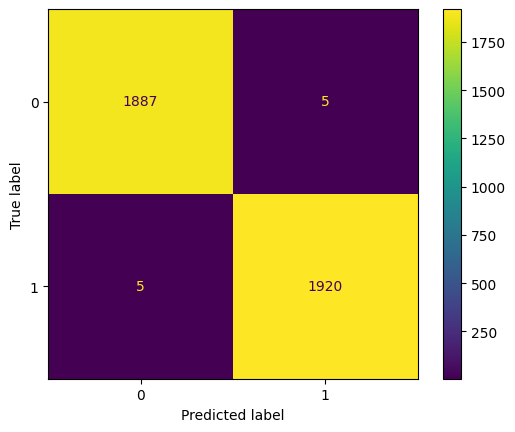

In [30]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix = log_cm, display_labels = None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()


Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.

In [31]:
# Create a classification report
# Create classification report for random forest model
target_labels = ["opinion", "claim"]
print(classification_report(y_val, y_pred, target_names = target_labels))


              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



**Question:** What does your classification report show? What does the confusion matrix indicate?

#### **XGBoost**

In [32]:
#Evaluate XGBoost model
y_pred = xgb_cv.best_estimator_.predict(x_val_final)


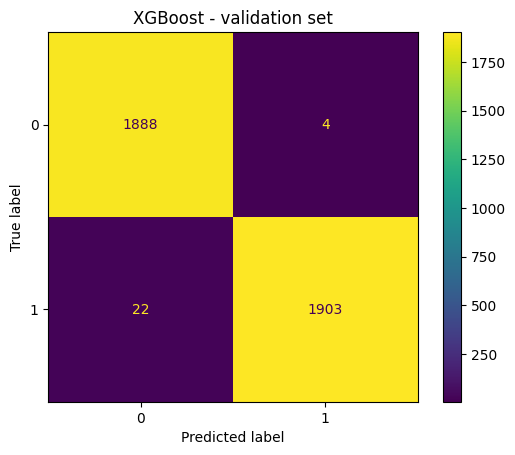

In [33]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()


In [34]:
# Create a classification report
target_labels = ["opinion", "claim"]
print(classification_report(y_val, y_pred, target_names = target_labels))


              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



**Question:** Describe your XGBoost model results. How does your XGBoost model compare to your random forest model?

### **Use champion model to predict on test data**

In [35]:
### YOUR CODE HERE ###
y_pred = rf_cv.best_estimator_.predict(x_test_final)

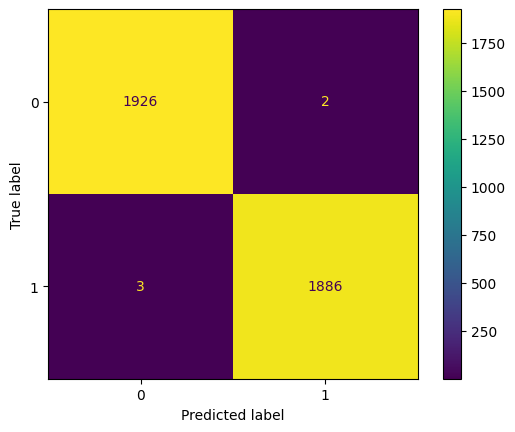

In [36]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix = log_cm, display_labels = None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()


#### **Feature importances of champion model**


In [37]:
Feature_importance = pd.DataFrame({"Coefficient" : rf_cv.best_estimator_.feature_importances_}, index = rf_cv.best_estimator_.feature_names_in_)
Feature_importance.sort_values(by = "Coefficient", ascending=False).head(10)

,Coefficient
video_view_count,0.617478
video_like_count,0.234227
video_share_count,0.068980
video_download_count,0.054842
video_comment_count,0.008691
media claim,0.002468
discussion board,0.001997
text_length,0.001425
colleague read,0.001266
news claim,0.001100


C:\Users\PC\AppData\Local\Temp\ipykernel_1040\124887822.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


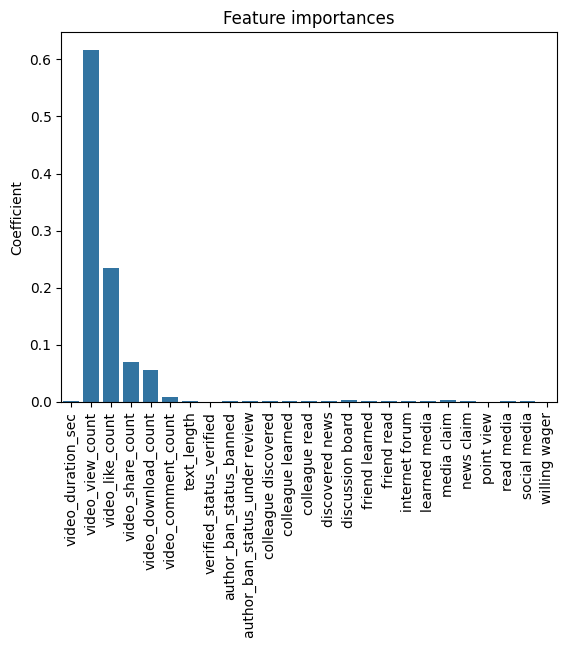

In [38]:

plot = sns.barplot(data = Feature_importance["Coefficient"])
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plt.title("Feature importances")
plt.show()